In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import time
from sklearn.preprocessing import RobustScaler

In [2]:
#定義device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# 注意需要將每個電池的 mat 檔放在此文記資料夾中
def load_data(batteries):
    # 初始化計數器和數據集列表
    counter = 0
    dataset = []
    capacity_data = []

    # 迭代處理每個電池
    for battery in batteries:
        # 載入 '.mat' 檔案中的數據
        mat = loadmat('battery_data/' + battery + '.mat')

        # 輸出總共的數據筆數
        print(f'{battery}的數據集總數: ', len(mat[battery][0, 0]['cycle'][0]))

        # 迭代處理每一個週期的數據
        for i in range(len(mat[battery][0, 0]['cycle'][0])):
            row = mat[battery][0, 0]['cycle'][0, i]

            # 只處理 'discharge' 類型的數據
            if row['type'][0] == 'discharge':
                ambient_temperature = row['ambient_temperature'][0][0]

                # 將時間信息轉換為 datetime 對象
                date_time = datetime.datetime(int(row['time'][0][0]),
                                              int(row['time'][0][1]),
                                              int(row['time'][0][2]),
                                              int(row['time'][0][3]),
                                              int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))

                data = row['data']
                capacity = data[0][0]['Capacity'][0][0]

                # 迭代處理每個時間步的數據
                for j in range(len(data[0][0]['Temperature_measured'][0])):
                    temperature_measured = data[0][0]['Temperature_measured'][0][j]
                    current_load = data[0][0]['Current_load'][0][j]
                    voltage_load = data[0][0]['Voltage_load'][0][j]
                    time = data[0][0]['Time'][0][j]

                    # 將數據添加到數據集中
                    dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                    temperature_measured, current_load,
                                    voltage_load, time])

                # 將電池容量數據添加到容量數據集中
                capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
                counter = counter + 1

    # 輸出第一筆數據
    print(dataset[0])

    # 返回數據集和電池容量數據集
    return [pd.DataFrame(data=dataset,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity', 'temperature_measured',
                                  'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                         columns=['cycle', 'ambient_temperature', 'datetime',
                                  'capacity'])]

# 使用 ['B0029', 'B0030', 'B0031', 'B0032'] 作為電池編號載入數據
dataset, capacity = load_data(['B0029','B0030','B0031','B0032'])

# 設置 pandas 的顯示選項
pd.set_option('display.max_columns', 100)

# 輸出數據集的前幾行
print(dataset.shape)
print(dataset)
# 輸出數據集的形狀(行數和列數)
print("Dataset Shape:", dataset.shape)

# 輸出第一個 cycle 的數據量
first_cycle_data_count = dataset[dataset['cycle'] == 1].shape[0]
print(f"Number of data points in the first cycle: {first_cycle_data_count}")

# 刪除 DataFrame 中的前2行(第1行的capacity應該要是最大)
dataset = dataset.iloc[169:]

# 重新設定索引,以確保索引是從零開始的連續整數
dataset.reset_index(drop=True, inplace=True)

# 輸出修改後的 DataFrame
print(dataset)


FileNotFoundError: ignored

In [ ]:
# 計算SOH
# 選取需要的特徵('cycle', 'datetime', 'capacity')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
# 刪除第一行(index=0)
dis_ele = dis_ele.drop(0, axis=0)

# 重新設置索引,以確保索引是連續的整數
dis_ele = dis_ele.reset_index(drop=True)

# 輸出修改後的 DataFrame

# 獲取初始電池容量(第一個循環的容量)
C = dis_ele['capacity'][0]

# 迭代處理每一行數據
for i in range(len(dis_ele)):
   # 計算電池狀態健康度(SoH),將其添加到 DataFrame 中
   dis_ele['SoH'] = (dis_ele['capacity']) / C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      2 2009-04-07 19:44:26  1.844701  1.000000
1      3 2009-04-07 22:58:18  1.825438  0.989557
2      4 2009-04-08 02:11:30  1.815750  0.984306
3      5 2009-04-08 05:23:26  1.813299  0.982977
4      6 2009-04-09 10:24:58  1.815165  0.983988


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Text(0.5, 1.0, 'Discharge B00029')

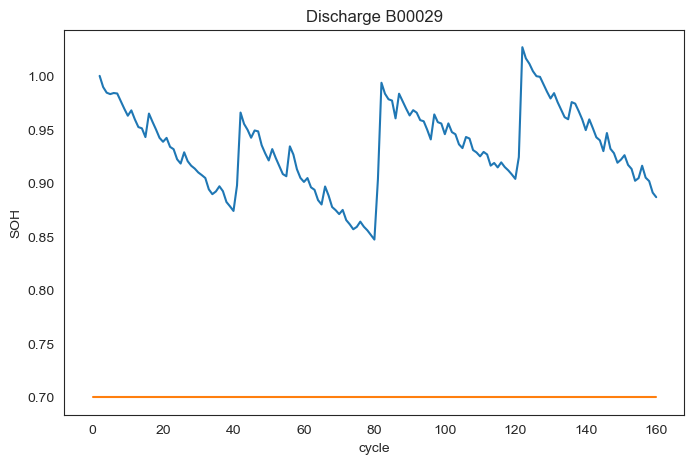

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B00029')

In [ ]:
# 從數據集中獲取初始電池容量
C = dataset['capacity'][0]
# 計算狀態健康度(SoH)並轉換為 PyTorch 张量
soh = torch.tensor(dataset['capacity'].values / C, dtype=torch.float32).view(-1, 1)
soh = soh.unsqueeze(1) # 添加一個額外的維度,以便與 CNN 兼容
print('soh:',soh.shape)
# 選取需要的特徵
attribs = ['capacity', 'temperature_measured','current_load', 'voltage_load', 'time']
# 提取所選屬性的特徵
train_dataset = torch.tensor(dataset[attribs].values, dtype=torch.float32)
# 正規化數據
# 使用 RobustScaler 進行正規化
robust_scaler = RobustScaler()
train_dataset = robust_scaler.fit_transform(train_dataset.numpy())
train_dataset = torch.tensor(train_dataset, dtype=torch.float32)
train_dataset = train_dataset.unsqueeze(1)
print('train_dataset:',train_dataset.shape)

soh: torch.Size([25235, 1, 1])
train_dataset: torch.Size([25235, 1, 5])


In [ ]:
# define LSTM model
class CNN_LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CNN_LSTM, self).__init__()
    #  第一層 CNN
    self.cnn1= nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=128, kernel_size=1),
    nn.ReLU(),
    )

    # MaxPool 層
    self.maxpool= nn.Sequential(
    nn.MaxPool1d(kernel_size=8),
    nn.Flatten()
    )

    #  第一層 LSTM
    self.lstm1= nn.LSTMCell(80, hidden_size) # 輸入通道數為 32*5
    self.dropout1= nn.Dropout(0.07)
    #  第二層 LSTM
    self.lstm2= nn.LSTMCell(hidden_size, hidden_size)
    self.dropout2= nn.Dropout(0.09)
    # 第三層 LSTM
    self.lstm3= nn.LSTMCell(hidden_size, hidden_size)
    self.dropout3= nn.Dropout(0.09)
    # 第四層 LSTM
    self.lstm4= nn.LSTMCell(hidden_size, hidden_size)
    self.dropout4= nn.Dropout(0.12)
    # 最後的全連接層
    self.fc= nn.Linear(hidden_size, output_size)
  def forward(self,x):
    # 第一層 CNN
    cnn_output = self.cnn1(x)
    cnn_output = cnn_output.permute(0, 2, 1)
    # 第一層 maxpool
    max_output = self.maxpool(cnn_output)
    # 第一層 LSTM
    h_t, c_t = self.lstm1(max_output)
    out = self.dropout1(h_t)
    # 第二層 LSTM
    h_t, c_t = self.lstm2(out)
    out = self.dropout2(h_t)
    # 第三層 LSTM
    h_t, c_t = self.lstm3(out)
    out = self.dropout3(h_t)
    # 第四層 LSTM
    h_t, c_t = self.lstm4(out)
    out = self.dropout4(h_t)
    # 最後的全連接層，取最後一個時間步的輸出
    out = self.fc(out)
    return out

In [ ]:
# Define the PyTorch model, loss function, and optimizer
input_size = len(attribs)
print(attribs)
hidden_size = 224
output_size = 1
regress = CNN_LSTM(input_size,hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regress.parameters(), lr=0.01)

['capacity', 'temperature_measured', 'current_load', 'voltage_load', 'time']


In [ ]:
# Convert the dataset and labels to PyTorch DataLoader
train_data = TensorDataset(train_dataset, soh)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
# Training the model
num_epochs = 50
start_time=time.time()
for epoch in range(num_epochs):
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = regress(inputs)
    loss = criterion(outputs, labels.squeeze(1))
    loss.backward()
    optimizer.step()
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
end_time=time.time()
print("training time:",end_time-start_time,"s")
regress = regress.to('cpu')

training time: 318.92404985427856 s


In [ ]:
# 載入驗證數據集
dataset_val, capacity_val = load_data(['B0029'])


# 選擇指定特徵
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]

# 刪除第1個cycle(第1項的capacity應該要是最大)
dataset_val = dataset_val.iloc[169:]
dis_ele = dis_ele.iloc[1:]
# 重新設定索引，以確保索引是從零開始的連續整數
dataset_val.reset_index(drop=True, inplace=True)
dis_ele.reset_index(drop=True, inplace=True)

# 計算初始容量並計算狀態健康度
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH'] = (dis_ele['capacity']) / C

# 刪除 DataFrame 中的前2行(第1行的capacity應該要是最大)
dataset_val = dataset_val.iloc[169:]

# 重新設定索引，以確保索引是從零開始的連續整數
dataset_val.reset_index(drop=True, inplace=True)

# 印出數據集的前五行
print(dataset_val.head(5))
print(dis_ele.head(5))

# 選擇其他特徵
attrib = ['capacity', 'temperature_measured', 'current_load', 'voltage_load', 'time']

B0029的數據集總數:  97
[1, 43, datetime.datetime(2009, 4, 7, 16, 31, 1), 1.697507332205763, 43.41517780938604, 0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  \
0      2                   43 2009-04-07 19:44:26  1.844701   
1      2                   43 2009-04-07 19:44:26  1.844701   
2      2                   43 2009-04-07 19:44:26  1.844701   
3      2                   43 2009-04-07 19:44:26  1.844701   
4      2                   43 2009-04-07 19:44:26  1.844701   

   temperature_measured  current_load  voltage_load      time  
0             57.718819         3.995         1.148  1589.250  
1             57.797304         3.995         1.122  1598.656  
2             57.904714         3.995         1.083  1608.078  
3             58.023008         3.995         1.050  1617.500  
4             58.160161         3.995         1.011  1626.875  
   cycle            datetime  capacity       SoH
0      2 2009-04-07 19:44:26  1.844701  1.000000
1      3 2009-04

In [ ]:
# Convert DataFrame to PyTorch tensor
dataset_val_tensor = torch.tensor(dataset_val[attrib].values, dtype=torch.float32)

# 使用 RobustScaler 進行正規化
robust_scaler = RobustScaler()
normalized_dataset_val_np = robust_scaler.fit_transform(dataset_val_tensor.numpy())
normalized_dataset_val = torch.tensor(normalized_dataset_val_np, dtype=torch.float32)
normalized_dataset_val = normalized_dataset_val.unsqueeze(1)
# Make predictions
soh_pred = regress(normalized_dataset_val)
print(soh_pred.size())

torch.Size([6013, 1])


In [ ]:
# Assuming 'dataset_val' has a 'cycle' column
new_soh = pd.DataFrame({
    'cycle': dataset_val['cycle'],
    'SoH': dataset_val['capacity'] / C,
    'NewSoH': soh_pred.cpu().detach().numpy().flatten()
})
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
new_soh['NewSoH'] = new_soh['NewSoH'] / new_soh['NewSoH'][0]
print(new_soh.head(10))

   cycle       SoH    NewSoH
0      2  1.000000  1.000000
1      3  0.989557  0.991017
2      4  0.984306  0.985971
3      5  0.982977  0.984933
4      6  0.983988  0.986339
5      7  0.983537  0.985192
6      8  0.976496  0.978366
7      9  0.969347  0.971293
8     10  0.962796  0.965270
9     11  0.967789  0.970581


Root Mean Square Error:  0.04823842410364765


C:\Users\E1025\AppData\Local\Temp\ipykernel_15832\1999344042.py:4: UserWarning: Using a target size (torch.Size([6013, 1])) that is different to the input size (torch.Size([39])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rms = torch.sqrt(F.mse_loss(torch.tensor(new_soh['SoH'].values), torch.tensor(predicted_soh_np)))


Text(0.5, 1.0, 'Discharge B0029')

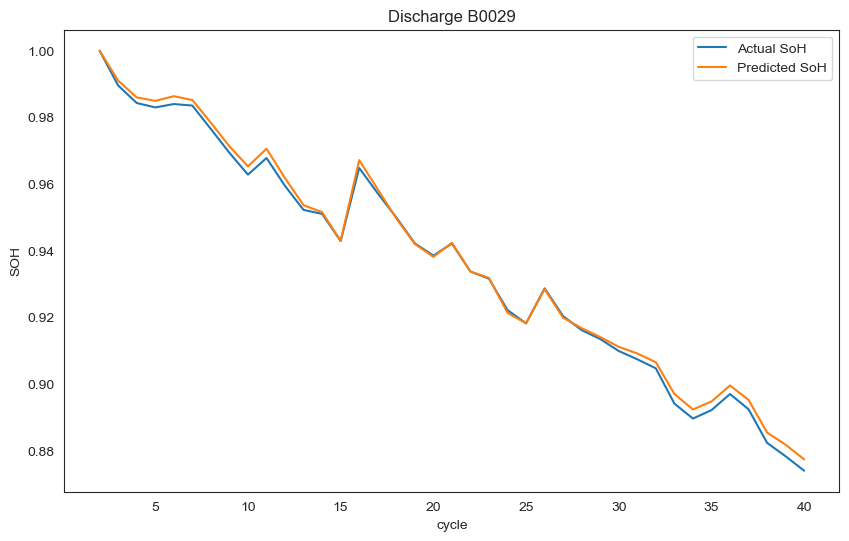

In [ ]:
# Calculate RMSE
predicted_soh_np = soh_pred.detach().numpy()
# 使用 PyTorch 提供的均方差函數計算 RMSE
rms = torch.sqrt(F.mse_loss(torch.tensor(new_soh['SoH'].values), torch.tensor(predicted_soh_np)))
print('Root Mean Square Error: ', rms.item())
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(10, 6))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='Actual SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0029')